# Google and NVIDA stock prices
In this notebook we analyze the historical data of two companies: Google (GOOG) and NVIDIA (NVDA). The aim is to figure out what kind of process is at the source of the stock prices in order to be able to use one time series model, e.g. randowm walk, moving average, or other to represent it. We also interested in studying whether there are similarities between the time series of the two stocks.

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## The datasets
The historical data have been download from the [Yahoo Finance](https://finance.yahoo.com/) website. The datasets contain the records from the beginning of 2019 to the beginning of 2024. The prices are recorded on working days, between monday and friday excluding holidays, when the stock market is open.

## GOOG
We start our anaylsis with the historical data of the GOOG stock prices from 2019-01-02 to 2024-01-08

In [37]:
path_google_ds = 'data/GOOG.csv'
google_tmp_df = pd.read_csv(path_google_ds)
google_tmp_df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
1258,2024-01-02,139.600006,140.615005,137.740005,139.559998,139.559998,20071900
1259,2024-01-03,138.600006,141.089996,138.429993,140.360001,140.360001,18974300
1260,2024-01-04,139.850006,140.634995,138.009995,138.039993,138.039993,18253300
1261,2024-01-05,138.352005,138.809998,136.850006,137.389999,137.389999,15433200
1262,2024-01-08,138.000000,140.639999,137.880005,140.529999,140.529999,17633700


In [7]:
num_records_googl = len(google_tmp_df)
num_records_googl

1263

We use the dates as the index of the dataset. We will use only the price at the time the market closes so we drop all the other columns.

In [44]:
stock_day_index = pd.date_range(start='2019-01-09', end='2024-01-08', freq='D')

In [12]:
day_index = pd.to_datetime(google_tmp_df['Date'])
google_tmp_df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
google_df = google_tmp_df.set_index(day_index)
google_df.head(2)

,Close
Date,
2019-01-02,52.292500
2019-01-03,50.803001


We plot the time series of the Google stock prices for a qualitative analysis of its components: trend, cycles, and random  

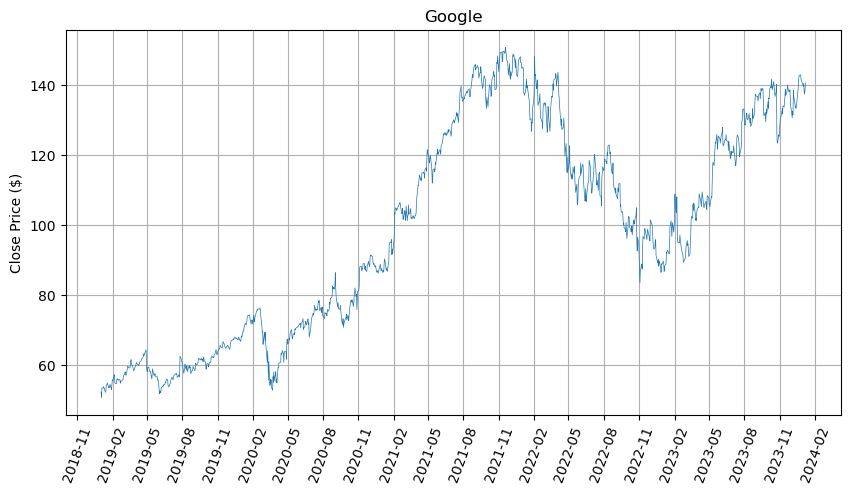

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Google')
ax.set_ylabel('Close Price ($)')
ax.set_xticks(google_df.index)
ax.set_xticklabels(google_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.MonthLocator([2, 5, 8, 11]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt_google = ax.plot(google_df, linewidth=0.5, label='google')
#plt.legend(loc='upper left')

From the plot we find out that there is a trend of rising prices and random fluctuations. This means that the time series is not stationary. We use the [Augmented Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) or ADF test to numerically determine whether the process is stationary or not. Since the result is lower than -1 and the p-value is greater than 0.05 we reject the null hypothesis of the time series being stationary. 

In [15]:
ADF_result = adfuller(google_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.2587556157629054
p-value: 0.6478242308425972


Since the stock price time series is non stationary we compute its first order difference. We will test whether the difference time series is stationary and in case we will use it for our analysis.  

In [16]:
google_close_diff = np.diff(google_df['Close'], n=1)
google_close_diff_df = pd.DataFrame({'Diff': google_close_diff}, index=day_index[1:])

We plot the first order difference and we can see that it looks stationary with random variations around a 0 mean value.

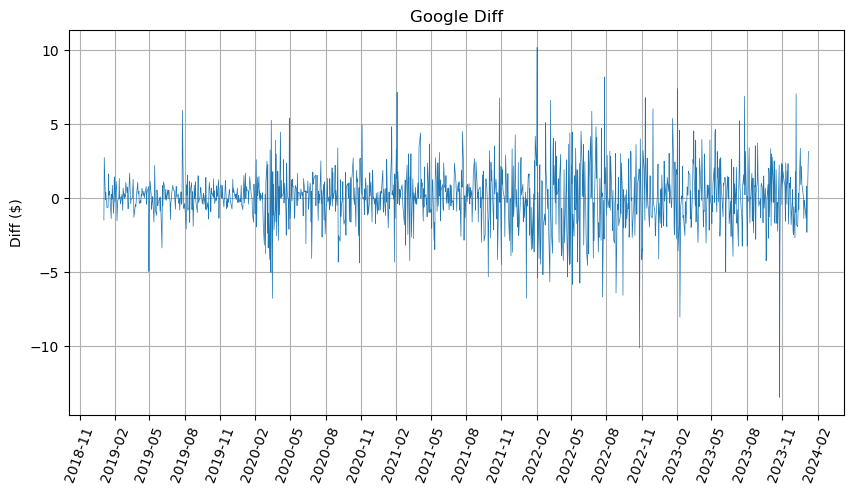

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Google Diff')
ax.set_ylabel('Diff ($)')
ax.set_xticks(google_close_diff_df.index)
ax.set_xticklabels(google_close_diff_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.MonthLocator([2, 5, 8, 11]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt_google_diff = ax.plot(google_close_diff_df, linewidth=0.5, label='google')
#plt.legend(loc='upper left')

We apply the ADF test to the first order time series to be sure that our qualitative estimation is correct. Since the result is a number far below -1 and the p-value is lower than 0.05 we cannot reject the null hypothesis of the difference time series being stationary.

In [18]:
ADF_result = adfuller(google_close_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -37.011103477336206
p-value: 0.0


## Autocorrelation
The next step is to verify whether there is a correlation between any to pair of elements in the time series that are separated by a certain number of time step or lags. We use the autocorrelation function that creates a plot of the autocorrelation coefficients. Since all the coefficients from lag=1 to lag=30 are not significant we can assume that the elements of the difference time series are not correlated. This means that the elements of the first order difference are random.

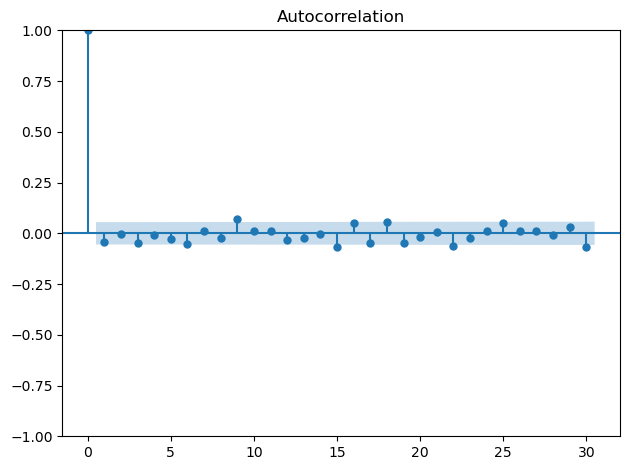

In [19]:
plot_acf(google_close_diff, lags=30);
plt.tight_layout()

In [10]:
train = google_close_diff[:int(0.9*len(google_close_diff))]
test = google_close_diff[int(0.9*len(google_close_diff)):]
print(len(train))
print(len(test))

1135
127


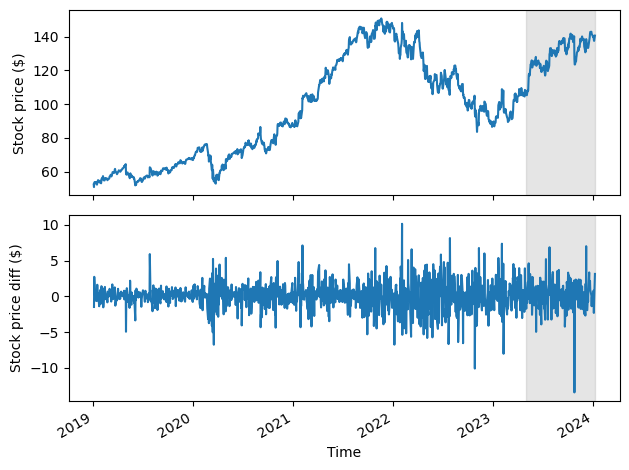

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(google_df['Close'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock price ($)')
ax1.axvspan('2023-05-01', '2024-01-08', color='#808080', alpha=0.2)

ax2.plot(google_close_diff_df['Diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Stock price diff ($)')
ax2.axvspan('2023-05-01', '2024-01-08', color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

## NVDA
Now we perform the same analysis of the historical data of the NVIDIA stock prices from 2019-01-09 to 2024-01-08

In [36]:
path_nvda_ds = 'data/NVDA.csv'
nvda_tmp_df = pd.read_csv(path_nvda_ds)
nvda_tmp_df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-09,35.474998,36.122501,34.965,35.645000,35.368126,61726000
1,2019-01-10,35.450001,36.395000,34.840,36.307499,36.025478,52315600


In [29]:
num_records_nvda = len(nvda_tmp_df)
num_records_nvda

1258

In [30]:
nvda_day_index = pd.to_datetime(nvda_tmp_df['Date'])
nvda_tmp_df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
nvda_df = nvda_tmp_df.set_index(nvda_day_index)
nvda_df.tail(2)

,Close
Date,
2024-01-05,490.970001
2024-01-08,522.530029


We plot the data of the two stocks

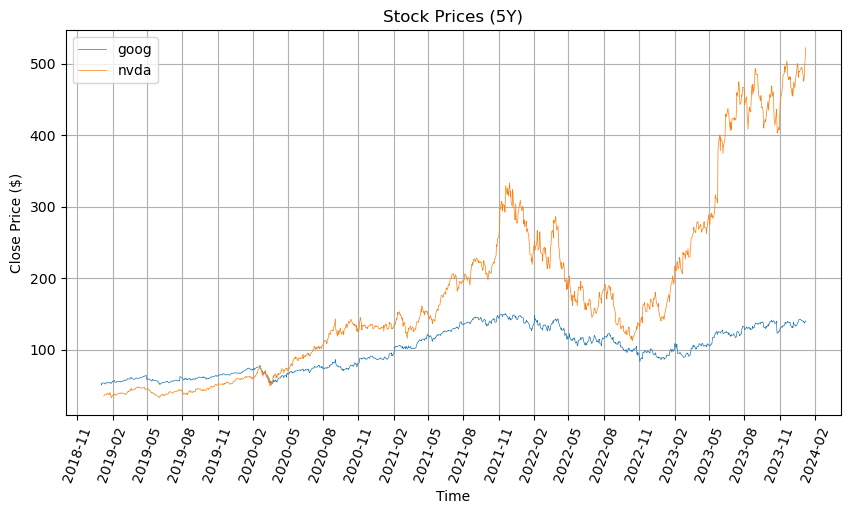

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Stock Prices (5Y)')
ax.set_ylabel('Close Price ($)')
ax.set_xlabel('Time')
ax.set_xticks(nvda_df.index)
ax.set_xticklabels(nvda_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.MonthLocator([2, 5, 8, 11]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt_google = ax.plot(google_df, linewidth=0.5, label='goog')
plt_nvda = ax.plot(nvda_df, linewidth=0.5, label='nvda')
plt.legend(loc='upper left')
plt.savefig('goog_nvda.jpg', dpi=300)

In [59]:
ADF_result = adfuller(nvda_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 0.7257438087513398
p-value: 0.9903378743650351


In [60]:
nvda_diff = np.diff(nvda_df['Close'], n=1)
nvda_diff_df = pd.DataFrame({'Diff': nvda_diff}, index=nvda_day_index[1:])

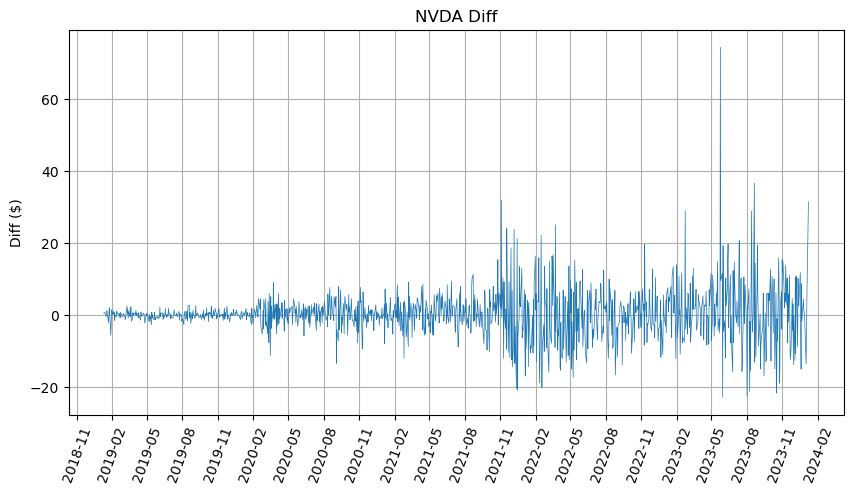

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('NVDA Diff')
ax.set_ylabel('Diff ($)')
ax.set_xticks(nvda_diff_df.index)
ax.set_xticklabels(nvda_diff_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.MonthLocator([2, 5, 8, 11]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt_google_diff = ax.plot(nvda_diff_df, linewidth=0.5, label='google')
#plt.legend(loc='upper left')

In [62]:
ADF_result = adfuller(nvda_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.874905254263723
p-value: 6.374791935743317e-22


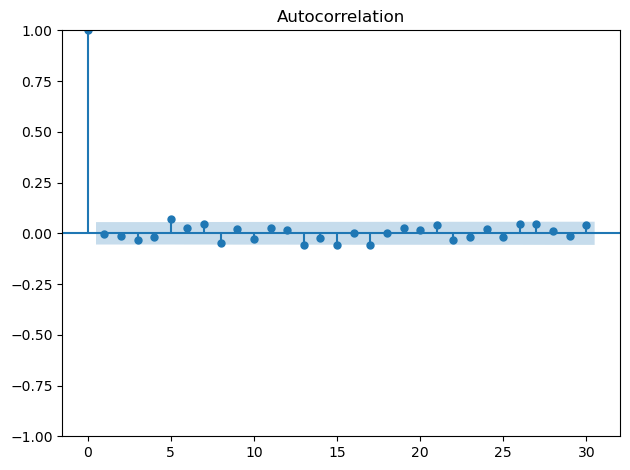

In [63]:
plot_acf(nvda_diff, lags=30);
plt.tight_layout()